# NLP for Twitter Sentiment Analysis (Hate Speech/Offensive Lang)

If at any point you need to install a package, come here and uncomment the corresponding line.

In [3]:
#!conda install -y pyspark
#!conda install -y -c conda-forge findspark
#!conda install -y keras
#!conda install -y tqdm
#!conda install -y gensim
#!pip install wget

#import nltk
#nltk.download('stopwords')

If you get an error related to JAVA_HOME or SPARK_HOME, you either don't have the jdk/pyspark installed or the paths are not set. Make sure you installed them. You may set the paths using the following (Warning: the paths may be different in your system!)

In [1]:
import os
os.environ["JAVA_HOME"] = "C:\Java"
os.environ["SPARK_HOME"] = "C:\Spark\spark-2.4.0-bin-hadoop2.7"

In [2]:
import findspark
findspark.init()

In [3]:

import warnings

import re
from datetime import datetime

import pandas as pd  
import numpy as np


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer

from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, concatenate, Activation, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import load_model, Model
from keras.preprocessing.sequence import pad_sequences

from bs4 import BeautifulSoup
from shutil import unpack_archive

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, auc, explained_variance_score, roc_curve

import pyspark as ps
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, NGram, StringIndexer, Tokenizer, VectorAssembler
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
try:
    # create SparkContext on 4 CPUs
    # feel free to increase it if you have more cores on your machine
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Created a new SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Created a new SparkContext


In [5]:
sc.master

'local[4]'

## Twitter data

### Download and load the data

You may either get and use your own data, or use the one I prepared. Just set the following variable and run the following code:

Note that you only have to download the data once. You may 

In [6]:
df=pd.read_csv("twitter-hate-speech-classifier.csv", encoding='latin1')
#f    = open("twitter-hate-speech-classifier.csv","rb")
#df = f.read().decode(errors='replace')

In [7]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech:confidence,_created_at,orig__golden,orig__last_judgment_at,orig__trusted_judgments,orig__unit_id,orig__unit_state,_updated_at,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speech_gold_reason,does_this_tweet_contain_hate_speechconfidence,tweet_id,tweet_text
0,853718217,True,golden,86,NaN,The tweet uses offensive language but not hate...,0.6013,NaN,True,NaN,0.0,615561535.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,1.666196e+09,Warning: penny boards will make you a faggot
1,853718218,True,golden,92,NaN,The tweet contains hate speech,0.7227,NaN,True,NaN,0.0,615561723.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.295121e+08,Fuck dykes
2,853718219,True,golden,86,NaN,The tweet contains hate speech,0.5229,NaN,True,NaN,0.0,615562039.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,3.956238e+08,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,True,golden,98,NaN,The tweet contains hate speech,0.5184,NaN,True,NaN,0.0,615562068.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.975147e+08,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,True,golden,88,NaN,The tweet uses offensive language but not hate...,0.5185,NaN,True,NaN,0.0,615562488.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,5.889236e+08,@Zhugstubble You heard me bitch but any way I'...


In [8]:
df.shape

(14509, 20)

### EDA

In [9]:
df['_unit_state'].unique()

array(['golden', 'finalized'], dtype=object)

In [10]:
df['_created_at'].unique()

array([nan])

In [11]:
df['orig__golden'].unique()

array([True, nan], dtype=object)

In [12]:
df.drop(['_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at','_created_at','orig__unit_id',
         'orig__golden', 'orig__trusted_judgments','orig__last_judgment_at', 'orig__unit_state','_updated_at','does_this_tweet_contain_hate_speech_gold_reason',
        'tweet_id'], axis=1, inplace=True)

In [13]:
df['_unit_id'].nunique()

14509

In [14]:
df.head()

,_unit_id,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech:confidence,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speechconfidence,tweet_text
0,853718217,The tweet uses offensive language but not hate...,0.6013,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Warning: penny boards will make you a faggot
1,853718218,The tweet contains hate speech,0.7227,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Fuck dykes
2,853718219,The tweet contains hate speech,0.5229,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,The tweet contains hate speech,0.5184,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,The tweet uses offensive language but not hate...,0.5185,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,@Zhugstubble You heard me bitch but any way I'...


In [15]:
df.loc[df['does_this_tweet_contain_hate_speech']!=df['does_this_tweet_contain_hate_speech_gold']]

,_unit_id,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech:confidence,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speechconfidence,tweet_text
0,853718217,The tweet uses offensive language but not hate...,0.6013,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Warning: penny boards will make you a faggot
1,853718218,The tweet contains hate speech,0.7227,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Fuck dykes
2,853718219,The tweet contains hate speech,0.5229,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,The tweet contains hate speech,0.5184,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,The tweet uses offensive language but not hate...,0.5185,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,@Zhugstubble You heard me bitch but any way I'...
6,853718223,The tweet contains hate speech,0.5207,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,RT @ivanrabago_: @_WhitePonyJr_ looking like f...
7,853718224,The tweet contains hate speech,0.5619,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,Well I thought you knew actually RT @KingHorse...
8,853718225,The tweet uses offensive language but not hate...,0.6419,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,"@Stonisnipezz I know. It was a joke, faggot."
9,853718226,The tweet uses offensive language but not hate...,0.6407,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,I'm tired of people saying I look like my brot...
10,853718227,The tweet contains hate speech,0.7619,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,1.0,#VoteBlue2014 Yeah. CUZ 8 million people in fa...


In [16]:
df['orig_does_this_tweet_contain_hate_speech'].isnull().sum()

14442

In [17]:
df['does_this_tweet_contain_hate_speech_gold'].isnull().sum()

14442

In [18]:
df['does_this_tweet_contain_hate_speech'].unique()

array(['The tweet uses offensive language but not hate speech',
       'The tweet contains hate speech', 'The tweet is not offensive'],
      dtype=object)

In [19]:
df.drop(['orig_does_this_tweet_contain_hate_speech', 'does_this_tweet_contain_hate_speech_gold',
         'does_this_tweet_contain_hate_speechconfidence'], axis=1, inplace=True)

In [20]:
df1=df[['does_this_tweet_contain_hate_speech','tweet_text']]

In [21]:
df1['does_this_tweet_contain_hate_speech']=df1['does_this_tweet_contain_hate_speech'].map({'The tweet is not offensive':0,
                                                'The tweet uses offensive language but not hate speech':1,
                                               'The tweet contains hate speech':2})

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


It looks like both training and test data is sorted by time. Let's shuffle them first:

In [39]:
df1.head()

,sentiment,tweet
0,1,warning penny boards will make you a faggot
1,2,fuck dykes
2,2,at least i dont look like jefree starr faggot
3,2,is a fag jackie jealous neeeee
4,1,you heard me bitch but any way i m back th tex...


In [40]:
df1.columns=["sentiment", 'tweet']

In [41]:
df1.head()

,sentiment,tweet
0,1,warning penny boards will make you a faggot
1,2,fuck dykes
2,2,at least i dont look like jefree starr faggot
3,2,is a fag jackie jealous neeeee
4,1,you heard me bitch but any way i m back th tex...


In [64]:
df1.groupby('sentiment').count()

,tweet
sentiment,
0,7274
1,4836
2,2399


([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 array([2399. , 2886.5, 3374. , 3861.5, 4349. , 4836.5, 5324. , 5811.5,
        6299. , 6786.5, 7274. ]),
 <a list of 3 Lists of Patches objects>)

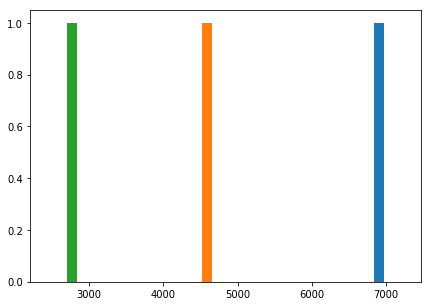

In [90]:
fig, ax = plt.subplots(figsize=(7, 5))
labels=['2399','4836','7274']
#plt.xticks((np.arange(0,3, step=1),labels)
plt.hist(df1.groupby('sentiment').count())
#

### Code clean up

We will use the following function to cleanup the data

In [25]:
df1["sentiment"] = df1["sentiment"].apply(lambda y: str(y)) 

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
def clean_tweet(tweet, remove_stopwords=False):
    # Remove HTML tags
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    
    # Remove "@..." mentions
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet)

    # Remove URLs that start with http, https or just www
    tweet = re.sub("https?://[^ ]+","",tweet)
    tweet = re.sub("www.[^ ]+","",tweet)

    # Decode and replace unicode unrecognisable special characters with u"\ufffd"
    try:
        tweet = tweet.decode("utf-8-sig")
    except:
        pass

    # now replace u"\ufffd" with "?"
    tweet.replace(u"\ufffd", "?")

    # TODO: Keep or replace emoticons and exclamations, etc. with text
    
    # Remove non-letters
    tweet = re.sub("[^a-zA-Z]"," ", tweet)
    
    # Convert text to lower case and tokenize them
    words = WordPunctTokenizer().tokenize(tweet.lower())

    # Remove stop words (false by default)
    if remove_stopwords:
        words = [w for w in words if w not in set(stopwords.words("english"))]

    # Join back the list of words
    cleaned_tweet = (" ".join(words)).strip()

    return cleaned_tweet

Let's test the above function on an example with all the patterns that it removes:

In [27]:
test_example = "@my_friend http://www.mywebsite.com/index.html?start=1 I\xef\xbf\xbdll" + \
                " say &quot;I have a dream&quot; :)" + \
                "come and see www.mywebsite.com/my_contact.html"
print(clean_tweet(test_example, False))

i ll say i have a dream come and see


We will be using only the text of the tweet and the sentiment fields, so let's get rid of the rest:

In [28]:
start = datetime.now()
print("Start : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

# The following code is identical to the above loop, but is more fancy
df1["tweet"] = df1["tweet"].apply(lambda x: clean_tweet(x))

end = datetime.now()
print("End : {0}".format(end.strftime("%Y-%m-%d %H:%M:%S")))
print("This step took {0:.3f} seconds".format((end-start).total_seconds()))

Start : 2019-01-02 22:12:18
End : 2019-01-02 22:12:23
This step took 5.315 seconds


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


The data seems to be perfectly balanced for training, but we have an extra level in test set. For now we will just ignore the level=2 which corresponds to neutral sentiment.

Let's rename 2 and 4 as 1 in the above data, so that we have binary target. 

In [29]:
df1.head()

,sentiment,tweet
0,1,warning penny boards will make you a faggot
1,2,fuck dykes
2,2,at least i dont look like jefree starr faggot
3,2,is a fag jackie jealous neeeee
4,1,you heard me bitch but any way i m back th tex...


In [30]:
from sklearn.model_selection import train_test_split
X=df1['tweet']
y=df1['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42)

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14218,), (14218,), (291,), (291,))

Let's test the above function on an example with all the patterns that it removes:

Let's save the results so that we can use them in the future, or start from here in future iterations to avoid the huge learning time above.

In [32]:
hate_tweets = "hate_tweets.csv"
df1.to_csv(hate_tweets, index=False, quoting=3, 
                quotechar='', escapechar='\\', encoding='utf-8')

## Models

### Scikit Learn Random Forest Classifier

For this model we will use the df_train and df_test data we created and wrote to their respective files above. We can directly use them since they are already in memory, but just for the sake of modularity and completeness, we will start from scratch and read them from the files into pandas dataframes:

Let's drop the rows with empty tweets, but let's first check the sizes of the dataframes:

It looks like we dropped a couple of thousand rows from df_train_new. Those were the tweets that became empty strings after the cleanup.

In [39]:
# Create a bag of words from the cleaned up reviews
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = stopwords.words("english"),   \
                             max_features = 5000)

# Fits the model and learn the vocabulary; then transforms the data into feature vectors
X_train_features = vectorizer.fit_transform(X_train)
X_train_features

<14218x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 88521 stored elements in Compressed Sparse Row format>

In [40]:
# Create a Random Forest classifier with 100 trees

rfc = RandomForestClassifier(n_estimators = 50)

We will do the training right now, but because we are not using spark for this model, it will take some time (approximately 6 minutes). Let's record the start and end time and compute the total run time of this step (feel free to change the CUSTOM_TRAINING_SET_SIZE to a lower number to reduce runtime, e.g. 100000):

In [41]:
start = datetime.now()
print("Start : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

# Fit the Random Forest classifier to the training set, using the bag of words as
# features and the sentiment labels as the response variable
rfc.fit(X_train_features, y_train)

end = datetime.now()
print("End : {0}".format(end.strftime("%Y-%m-%d %H:%M:%S")))
print("This step took {0:.3f} seconds".format((end-start).total_seconds()))

Start : 2019-01-02 15:43:56
End : 2019-01-02 15:44:16
This step took 19.813 seconds


Let's first calculate the accuracy on the exact subset of the training set we used for training:

In [42]:
X_train_features = vectorizer.transform(X_train)
Y_train_pred = rfc.predict(X_train_features)
acc_score = accuracy_score(y_train, Y_train_pred)
print("accuracy_score={}".format(acc_score))

accuracy_score=0.9642706428470952


 on the independent test set:

In [43]:
# transform and predict the test set
X_test_features = vectorizer.transform(X_test)
Y_test_pred = rfc.predict(X_test_features)
acc_score = accuracy_score(y_test, Y_test_pred)
print("accuracy_score={}".format(acc_score))

accuracy_score=0.7628865979381443


In [44]:
Yhat_rf = rfc.predict_proba(X_test_features)
fpr, tpr, threshold = roc_curve(y_test.apply(lambda y:0 if y=='0' else 1), Yhat_rf[:,1])
roc_auc = auc(fpr, tpr)
print("AUC={}".format(roc_auc))

AUC=0.9346128360469519


### Scikit Learn Logistic Regression with tf-idf

In [45]:
df1.head()

,sentiment,tweet
0,1,warning penny boards will make you a faggot
1,2,fuck dykes
2,2,at least i dont look like jefree starr faggot
3,2,is a fag jackie jealous neeeee
4,1,you heard me bitch but any way i m back th tex...


In [46]:
start = datetime.now()
print("Start : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

# The following code is identical to the above loop, but is more fancy
df1["tweet"] = df1["tweet"].apply(lambda x: clean_tweet(x))

end = datetime.now()
print("End : {0}".format(end.strftime("%Y-%m-%d %H:%M:%S")))
print("This step took {0:.3f} seconds".format((end-start).total_seconds()))

Start : 2019-01-02 15:44:17
End : 2019-01-02 15:44:23
This step took 5.857 seconds


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Let's do the splits:

In [94]:
from sklearn.model_selection import train_test_split
X=df1['tweet']
y=df1['sentiment'].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=42, test_size=0.2)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

USE_NUMBERS = True
if USE_NUMBERS:
    Y_train = Y_train.apply(lambda y: 0 if y=="0" else 1)
    Y_valid = Y_valid.apply(lambda y: 0 if y=="0" else 1)
    Y_test = Y_test.apply(lambda y: 0 if y=="0" else 1)
else:
    Y_train = Y_train.apply(lambda y: "Neg" if y=="0" else "Pos")
    Y_valid = Y_valid.apply(lambda y: "Neg" if y=="0" else "Pos")
    Y_test = Y_test.apply(lambda y: "Neg" if y=="0" else "Pos")

In [95]:
Y_test.shape

(2902,)

In [96]:
NUM_WORDS = 100000

To prepare the input for the Logistic Regression model, create and fit a tf-idf vectorizer:

In [97]:
tvec = TfidfVectorizer(max_features=NUM_WORDS,ngram_range=(1, 3), decode_error='replace', max_df=0.6, min_df=5)
tvec.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='replace',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.6, max_features=100000, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Now transform the training and test data:

In [98]:
X_train_tfidf = tvec.transform(X_train)
X_test_tfidf = tvec.transform(X_test)

We will now fit a Logistic Regression model to the tf-idf encoded data.

In [99]:
from sklearn.linear_model import LogisticRegression

lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(X_train_tfidf,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Here is this models accuracy score on the validation set:

And here is the accuracy score of the test set:

In [100]:
lr_with_tfidf.score(X_test_tfidf,Y_test)

0.7715368711233632

It looks like the accuracy of the Logistic Regression model was much better than the Random Forest Model and it also took a franction of the time to train.

Let's create the prediction probabilities for the test set (which we will need while creating the ROC curve):

In [106]:
from sklearn.metrics import classification_report
y_preds=lr_with_tfidf.predict(X_test_tfidf)
report = classification_report( Y_test, y_preds )
print(report)
#It turns out that Logistic Regression model does better to predict offensive language that hate speech. It is relevant
#with our data which consist more offensive tweets and ofefnsive tweets are wrongly labeled as 'hate speech' by users

             precision    recall  f1-score   support

          0       0.85      0.98      0.91      1459
          1       0.70      0.68      0.69       953
          2       0.55      0.32      0.41       490

avg / total       0.75      0.77      0.75      2902



In [161]:
Yhat_lr = lr_with_tfidf.predict_proba(X_test_tfidf)

### Load the data for modeling on Spark

Let's load the training dataset

In [55]:
spark_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(hate_tweets)

In [56]:
spark_df = spark_df.withColumn('index', monotonically_increasing_id())

In [57]:
spark_df.head()

Row(sentiment=1, tweet='warning penny boards will make you a faggot', index=0)

In [58]:
(spark_df_train, spark_df_valid, spark_df_test) = spark_df.randomSplit([0.80, 0.05, 0.05], seed = 0)

In [59]:
spark_df_train.count(), spark_df_valid.count(), spark_df_test.count()

(12938, 785, 786)

### Logistic Regression with tf-idf on Spark (model #1)

<B>Note</B>: The following models are from the following website. You may find more detailed models for Twitter Sentiment Analysis there:
https://towardsdatascience.com/sentiment-analysis-with-pyspark-bc8e83f80c35

In [61]:
# import the pyspark's CountVectorizer to be used in the following examples
# The import is here because we used similar modules from scikit-learn above
from pyspark.ml.feature import CountVectorizer, Tokenizer
from pyspark.ml.classification import LogisticRegression

In [87]:
start = datetime.now()
print("Start : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=100000, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

# tf-idf and conversions
pipelineFit = pipeline.fit(spark_df_train)
spark_df_train_transformed = pipelineFit.transform(spark_df_train)
spark_df_valid_transformed = pipelineFit.transform(spark_df_valid)
spark_df_test_transformed = pipelineFit.transform(spark_df_test)

# modeling
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(spark_df_train_transformed)
validation_predictions = lrModel.transform(spark_df_valid_transformed)
test_predictions = lrModel.transform(spark_df_test_transformed)

end = datetime.now()
print("End : {0}".format(end.strftime("%Y-%m-%d %H:%M:%S")))
print("This step took {0:.3f} seconds".format((end-start).total_seconds()))

Start : 2019-01-02 17:04:35
End : 2019-01-02 17:04:49
This step took 14.023 seconds


In [88]:
number_of_matches = validation_predictions.filter(validation_predictions.label == validation_predictions.prediction).count()
validation_set_accuracy =  number_of_matches / float(validation_predictions.count())
validation_set_accuracy

0.7031847133757961

In [89]:
# AUC (Area Under the Curve metric)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(test_predictions)

0.8446416426466334

In [90]:
number_of_matches = test_predictions.filter(test_predictions.label == test_predictions.prediction).count()
test_set_accuracy =  number_of_matches / float(test_predictions.count())
test_set_accuracy

0.7048346055979644

The above result is on par with our previous Random Forest model, but a bit worse than the similar Logistic Regression model using tf-idf. The impressive part was that the whole run was done in less than 2 minutes due to spark leveraging parallelism using multiple cores.

### Logistic Regression with N-gram on Spark

We will extract around 6000 features from unigrams, bigrams and trigrams; hence 18000 features in total.

In [100]:
VOCAB_SIZE = 6000

def build_ngrams(inputCol=["tweet","sentiment"], n=3):
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]

    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=VOCAB_SIZE,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=2) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )] #Spark does not automatically combine features from different n-grams, so I had to use VectorAssembler in the pipeline, 
       #to combine the features I get from each n-gram.
    
    label_stringIdx = [StringIndexer(inputCol = "sentiment", outputCol = "label")]
    
    lr = [LogisticRegression(maxIter=100)]
    
    return Pipeline(stages = tokenizer + ngrams + cv + idf + assembler + label_stringIdx + lr)

In [96]:
start = datetime.now()
print("Start : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

ngram_pipelineFit = build_ngrams().fit(spark_df_train)

validation_predictions = ngram_pipelineFit.transform(spark_df_valid)
test_predictions = ngram_pipelineFit.transform(spark_df_test)

end = datetime.now()
print("End : {0}".format(end.strftime("%Y-%m-%d %H:%M:%S")))
print("This step took {0:.3f} seconds".format((end-start).total_seconds()))

Start : 2019-01-02 21:21:30
End : 2019-01-02 21:22:05
This step took 35.151 seconds


In [97]:
number_of_matches = validation_predictions.filter(validation_predictions.label == validation_predictions.prediction).count()
validation_set_accuracy =  number_of_matches / float(validation_predictions.count())
validation_set_accuracy

0.7235668789808917

In [98]:
# AUC (Area Under the Curve metric)
evaluator.evaluate(test_predictions)

0.8648119959840666

In [99]:
number_of_matches = test_predictions.filter(test_predictions.label == test_predictions.prediction).count()
test_set_accuracy =  number_of_matches / float(test_predictions.count())
test_set_accuracy

0.7404580152671756

## Logistic Regression w Feature Engineering, Credits for Thomas Davidson, Dana Warmsley, Michael Macy, and Ingmar Weber. 2017. 

In [164]:
import pandas as pd
import numpy as np
import pickle
import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

### Feature generation

In [191]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    #tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    #Convert to lower case, split into individual words:
    tweet= word_tokenize(tweet.lower())
    #tokens = re.split("[^a-zA-Z]*", tweet.lower())
    tokens = [stemmer.stem(t) for t in tweet]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    #tweet=word_tokenize(tweet.lower())
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords, #We do better when we keep stopwords
    use_idf=True,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.501
    )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [174]:
tweets=df1.tweet
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [210]:
vocab.items()

dict_items([('aap', 0), ('abandon', 1), ('abil', 2), ('abl', 3), ('abort', 4), ('abov', 5), ('absolut', 6), ('abt', 7), ('abus', 8), ('acc', 9), ('accent', 10), ('accept', 11), ('accid', 12), ('accomplish', 13), ('accord', 14), ('account', 15), ('account tri', 16), ('accur', 17), ('accus', 18), ('achiev', 19), ('across', 20), ('across field', 21), ('across field bag', 22), ('act', 23), ('act like', 24), ('act like faggot', 25), ('act like fuck', 26), ('action', 27), ('activ', 28), ('actor', 29), ('actual', 30), ('ad', 31), ('ad video', 32), ('ad video playlist', 33), ('add', 34), ('addict', 35), ('address', 36), ('adel', 37), ('admit', 38), ('adopt', 39), ('ador', 40), ('adult', 41), ('advantag', 42), ('advic', 43), ('af', 44), ('afford', 45), ('afraid', 46), ('africa', 47), ('african', 48), ('age', 49), ('agenc', 50), ('ago', 51), ('agre', 52), ('ah', 53), ('ahead', 54), ('ahh', 55), ('aid', 56), ('aim', 57), ('aint', 58), ('aint makin', 59), ('aint makin nois', 60), ('air', 61), ('ai

In [192]:
#Get POS tags for tweets and save as a string
#more details https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    #for i in range(0, len(tokens)):
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
        #print(tokens[i],tag_list[i])

C:\Users\user\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [196]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None, #We do better when we keep stopwords
    use_idf=False,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.501,
    )

In [197]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [219]:
#Now get other features
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    ##SENTIMENT
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet) #Count #, @, and http://
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [220]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", "vader compound", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [221]:
feats = get_feature_array(tweets)

In [204]:
tfidf, pos

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [222]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
#M = np.concatenate([tfidf,pos],axis=1)

In [223]:
M.shape

(14509, 8167)

In [224]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names
#feature_names = variables+pos_variables

### Running the model
This model was found using a GridSearch with 5-fold cross validation. 

In [225]:
X = pd.DataFrame(M)
y = df1['sentiment'].astype(int)

In [226]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

In [227]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))
X_ = select.fit_transform(X,y)

In [228]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_, y)

In [229]:
y_preds = model.predict(X_)

In [230]:
report = classification_report( y, y_preds )

In [231]:
print(report)

             precision    recall  f1-score   support

          0       0.92      0.95      0.93      7274
          1       0.76      0.64      0.70      4836
          2       0.52      0.61      0.56      2399

avg / total       0.80      0.79      0.79     14509



### Word2Vec + Keras Convolutional Neural Network

We will use the Word2Vec representation. 

"Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words." 

In Gensim package, you can specify whether to use CBOW or Skip-gram by passing the argument "sg" when implementing Word2Vec. By default (sg=0), CBOW is used. Otherwise (sg=1), skip-gram is employed. 

For example, let's say we have a following sentence: "I love dogs". CBOW model tries to predict the word "love" when given "I", "dogs" as inputs, on the other hand Skip-gram model tries to predict "I", "dogs" when given the word "love" as input.

Below picture represents more formally how these two models work.

<IMG SRC="https://cdn-images-1.medium.com/max/1600/1*6YmcrrGj1_wAmv0BQBarhw.png">

In [107]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

C:\Users\user\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [127]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

In [128]:
train_set, valid_set, test_set = train_validate_test_split(df1)

X_train = train_set["tweet"]
Y_train = train_set["sentiment"]
X_valid = valid_set["tweet"]
Y_valid = valid_set["sentiment"]
X_test = test_set["tweet"]
Y_test = test_set["sentiment"]

Labelize each tweet with a unique id:

In [129]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [130]:
all_x_w2v = labelize_tweets_ug(df1["tweet"], 'all')

In [131]:
all_x_w2v[5]

TaggedDocument(words=['your', 'a', 'dirty', 'terrorist', 'and', 'your', 'religion', 'is', 'a', 'fucking', 'joke', 'you', 'go', 'around', 'screaming', 'allah', 'akbar', 'doing', 'terrorist', 'shit', 'dirty', 'faggot'], tags=['all_5'])

Get the number of cores available in your system:

In [132]:
num_cores = multiprocessing.cpu_count()
num_cores

4

We will use it to set how many workers we would like to run in parallel (feel free to use a smaller number)

Now let's build the skip-gram model (note the "sg=1" argument in the Word2Vec call)

In [133]:
WORD2VEC_SIZE = 100
model_ug_sg = Word2Vec(sg=1, size=WORD2VEC_SIZE, negative=5, window=2, min_count=2, 
                       workers=num_cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|████████████████████████████████████████████████████████████████████████| 14509/14509 [00:00<00:00, 907432.66it/s]


In [134]:
model_ug_sg

Train it for 30 epochs (iterations) using all the labelized inputs (all_x_w2v):

In [135]:
for epoch in range(10):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), 
                      total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|████████████████████████████████████████████████████████████████████████| 14509/14509 [00:00<00:00, 967875.26it/s]


Build the embeddings_index (word to embedding mapping, for easy lookup) using the model_ug_sg model results. Youmay append more than one model's results here (see homework questions) 

In [136]:
embeddings_index = {}
for w in model_ug_sg.wv.vocab.keys():
    embeddings_index[w] = model_ug_sg.wv[w]

Use the last "w" value to get the size for embedding vectors

In [137]:
EMBEDDINGS_SIZE = len(embeddings_index[w])
print('Found %s word vectors of size %s' % (len(embeddings_index), EMBEDDINGS_SIZE))

Found 7482 word vectors of size 100


Tokenize the input tweets into sequence of word representations:

In [138]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)

Let's check the the maximum number of words a tweet has in our training set:

In [139]:
MAX_LENGTH = 0
for x in X_train:
    x_length = len(x.split())
    if x_length > MAX_LENGTH:
        MAX_LENGTH = x_length

MAX_LENGTH

34

Thus, the maximum number of words in a tweet within the training data is 45. To be on the safe size, we will set the maximum length of the sequences to 50 (you may go higher, but that will take more space). We will pad the shorter sequences using the pad_sequences function from Keras.

In [140]:
MAX_LENGTH = 35

In [141]:
sequences_train = tokenizer.texts_to_sequences(X_train)
X_train_seq = pad_sequences(sequences_train, maxlen=MAX_LENGTH)
print('Shape of training data tensor:', X_train_seq.shape)

Shape of training data tensor: (8705, 35)


Here is now it looks like (by default, Keras places a zero-padding at the beginning of the sequence):

In [142]:
X_train_seq[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  171,   18,  174,  147,  235,   71,  214,
         290,  160],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  541,
         203,    6,  161,   18,   11,  123,    3,  151,   12,   32,  137,
           1,   96],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  256,
          10,   15,   55,    8,  103, 5322, 1818,   11, 2124,    6, 2644,
        5323,    9],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   47, 2645,   48,  241,  154,  892,  280,
          50,  155],
       [   0,    0,    0,   

Now, let's do the same for the validation set:

In [143]:
sequences_valid = tokenizer.texts_to_sequences(X_valid)
X_valid_seq = pad_sequences(sequences_valid, maxlen=MAX_LENGTH)
print('Shape of validation data tensor:', X_valid_seq.shape)

Shape of validation data tensor: (2901, 35)


... and also the test set:

In [144]:
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(sequences_test, maxlen=MAX_LENGTH)
print('Shape of test data tensor:', X_test_seq.shape)

Shape of test data tensor: (2903, 35)


Let's check the size of the tokenizer word index:

Now we can generate the embedding_matrix (the matrix of embeddings for all words):

In [145]:
embedding_matrix = np.zeros((NUM_WORDS, EMBEDDINGS_SIZE))
for word, i in tokenizer.word_index.items():
    if i >= NUM_WORDS:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # embedding vectors lenght is 100

In [146]:
embedding_matrix[5]

array([-0.0225263 , -0.2118109 ,  0.24931687,  0.01480665,  0.13254005,
       -0.20635621, -0.01730832,  0.14405814, -0.09318416,  0.5671739 ,
       -0.14281207,  0.2497136 ,  0.35093439,  0.26466158,  0.63157713,
        0.15533064,  0.2381909 ,  0.06052995, -0.09094279, -0.29695177,
        0.49278367, -0.19765331,  0.21745673,  0.05567987, -0.34864944,
       -0.35937759,  0.6170122 , -0.07464511, -0.14967354, -0.17001393,
       -0.19983515,  0.2378765 ,  0.10040831,  0.49678108, -0.0267651 ,
       -0.28077805, -0.15237866, -0.12894255, -0.34791484, -0.14757393,
       -0.18990237, -0.38726541, -0.02517139,  0.44125456, -0.48438194,
        0.38597184,  0.07317051,  0.40041244,  0.26231167, -0.03688072,
       -0.00854358, -0.21939629, -0.07347817,  0.17532299, -0.5194245 ,
        0.04909679, -0.27985653,  0.16722509, -0.55433118, -0.02230527,
        0.18727635,  0.18431625,  0.06054831,  0.15568703,  0.19964884,
        0.01544949, -0.3564685 ,  0.16930853, -0.30353513,  0.65

We are now ready to build our CNN model.

We will use the embedding_matrix to initialize the weights of the Embedding layer called "tweet_encoder". We don't want to use a pre-trained one, as it would be generic and may not fit the specific (tweet data we have). Also we don't want to train one from scratch, because it may overfit our training data.

We will create one dimensional convolutional layers for bigrams, trigrams and fourgrams.

In [151]:
tweet_input = Input(shape=(MAX_LENGTH,), dtype='int32')

tweet_encoder = Embedding(NUM_WORDS, EMBEDDINGS_SIZE, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 100)      10000000    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 34, 100)      20100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 33, 100)      30100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (

Limiting the training set. Please uncomment an use the original values when you have enough time.

In [152]:
# Size of the dataset to learn from
CUSTOM_TRAINING_SET_SIZE = 600000 # X_train_seq.shape[0]
CUSTOM_VALIDATION_SET_SIZE = 300000 # X_valid_seq.shape[0]

We will run the training for 5 epochs (iterations)

In [153]:
NUM_EPOCHS = 5

In [154]:
start = datetime.now()
print("Start : {0}".format(start.strftime("%Y-%m-%d %H:%M:%S")))

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(X_train_seq[:CUSTOM_TRAINING_SET_SIZE], 
          Y_train[:CUSTOM_TRAINING_SET_SIZE], 
          batch_size=32,
          epochs=NUM_EPOCHS,
          validation_data=(X_valid_seq[:CUSTOM_VALIDATION_SET_SIZE], Y_valid[:CUSTOM_VALIDATION_SET_SIZE]),
          callbacks = [checkpoint])

end = datetime.now()
print("End : {0}".format(end.strftime("%Y-%m-%d %H:%M:%S")))
print("This step took {0:.3f} seconds".format((end-start).total_seconds()))

Start : 2019-01-03 01:40:00
Train on 8705 samples, validate on 2901 samples
Epoch 1/5


6464/8705 [=====================>........] - ETA: 13:23 - loss: 0.7559 - acc: 0.40 - ETA: 7:18 - loss: 0.5846 - acc: 0.4375 - ETA: 5:14 - loss: 0.5092 - acc: 0.447 - ETA: 4:12 - loss: 0.4192 - acc: 0.421 - ETA: 3:35 - loss: 0.6269 - acc: 0.393 - ETA: 3:10 - loss: 0.6586 - acc: 0.406 - ETA: 2:52 - loss: 0.6529 - acc: 0.397 - ETA: 2:39 - loss: 0.6121 - acc: 0.394 - ETA: 2:28 - loss: 0.6059 - acc: 0.388 - ETA: 2:20 - loss: 0.5970 - acc: 0.415 - ETA: 2:13 - loss: 0.5957 - acc: 0.443 - ETA: 2:08 - loss: 0.6059 - acc: 0.450 - ETA: 2:03 - loss: 0.6279 - acc: 0.451 - ETA: 1:59 - loss: 0.6328 - acc: 0.466 - ETA: 1:55 - loss: 0.6280 - acc: 0.481 - ETA: 1:52 - loss: 0.6274 - acc: 0.478 - ETA: 1:49 - loss: 0.6175 - acc: 0.481 - ETA: 1:47 - loss: 0.6142 - acc: 0.482 - ETA: 1:44 - loss: 0.6230 - acc: 0.473 - ETA: 1:42 - loss: 0.6122 - acc: 0.468 - ETA: 1:40 - loss: 0.6005 - acc: 0.470 - ETA: 1:38 - loss: 0.6036 - acc: 0.468 - ETA: 1:36 - loss: 0.5906 - acc: 0.472 - ETA: 1:35 - loss: 0.5832 - acc: 0.

8705/8705 [==============================] - ETA: 21s - loss: -0.9140 - acc: 0.654 - ETA: 20s - loss: -0.9085 - acc: 0.655 - ETA: 20s - loss: -0.9055 - acc: 0.656 - ETA: 20s - loss: -0.9126 - acc: 0.656 - ETA: 19s - loss: -0.9170 - acc: 0.656 - ETA: 19s - loss: -0.9317 - acc: 0.657 - ETA: 19s - loss: -0.9415 - acc: 0.657 - ETA: 18s - loss: -0.9474 - acc: 0.657 - ETA: 18s - loss: -0.9447 - acc: 0.658 - ETA: 18s - loss: -0.9395 - acc: 0.659 - ETA: 17s - loss: -0.9508 - acc: 0.659 - ETA: 17s - loss: -0.9493 - acc: 0.660 - ETA: 17s - loss: -0.9485 - acc: 0.660 - ETA: 16s - loss: -0.9671 - acc: 0.660 - ETA: 16s - loss: -0.9734 - acc: 0.660 - ETA: 16s - loss: -0.9746 - acc: 0.661 - ETA: 16s - loss: -0.9829 - acc: 0.661 - ETA: 15s - loss: -0.9940 - acc: 0.661 - ETA: 15s - loss: -0.9995 - acc: 0.661 - ETA: 15s - loss: -1.0010 - acc: 0.661 - ETA: 14s - loss: -1.0036 - acc: 0.661 - ETA: 14s - loss: -1.0024 - acc: 0.662 - ETA: 14s - loss: -1.0024 - acc: 0.662 - ETA: 13s - loss: -1.0035 - acc: 0.6

6528/8705 [=====================>........] - ETA: 1:09 - loss: -1.5260 - acc: 0.81 - ETA: 1:10 - loss: -1.7018 - acc: 0.82 - ETA: 1:11 - loss: -2.0151 - acc: 0.77 - ETA: 1:10 - loss: -2.3883 - acc: 0.74 - ETA: 1:10 - loss: -2.3129 - acc: 0.75 - ETA: 1:09 - loss: -2.2479 - acc: 0.76 - ETA: 1:09 - loss: -2.1386 - acc: 0.78 - ETA: 1:08 - loss: -2.0940 - acc: 0.78 - ETA: 1:08 - loss: -2.1092 - acc: 0.79 - ETA: 1:07 - loss: -2.0223 - acc: 0.79 - ETA: 1:07 - loss: -2.1216 - acc: 0.78 - ETA: 1:07 - loss: -2.0692 - acc: 0.79 - ETA: 1:06 - loss: -1.9626 - acc: 0.79 - ETA: 1:06 - loss: -1.8521 - acc: 0.80 - ETA: 1:06 - loss: -1.9122 - acc: 0.79 - ETA: 1:06 - loss: -1.9953 - acc: 0.78 - ETA: 1:06 - loss: -1.9500 - acc: 0.79 - ETA: 1:07 - loss: -1.9038 - acc: 0.79 - ETA: 1:06 - loss: -1.9540 - acc: 0.79 - ETA: 1:06 - loss: -1.9446 - acc: 0.79 - ETA: 1:06 - loss: -1.9698 - acc: 0.79 - ETA: 1:06 - loss: -1.9553 - acc: 0.79 - ETA: 1:06 - loss: -1.9690 - acc: 0.79 - ETA: 1:06 - loss: -1.9424 - acc: 0.

8705/8705 [==============================] - ETA: 20s - loss: -2.0191 - acc: 0.780 - ETA: 19s - loss: -2.0141 - acc: 0.781 - ETA: 19s - loss: -2.0099 - acc: 0.781 - ETA: 19s - loss: -2.0114 - acc: 0.781 - ETA: 18s - loss: -2.0249 - acc: 0.781 - ETA: 18s - loss: -2.0237 - acc: 0.781 - ETA: 18s - loss: -2.0228 - acc: 0.781 - ETA: 17s - loss: -2.0262 - acc: 0.781 - ETA: 17s - loss: -2.0279 - acc: 0.781 - ETA: 17s - loss: -2.0176 - acc: 0.782 - ETA: 17s - loss: -2.0184 - acc: 0.781 - ETA: 16s - loss: -2.0189 - acc: 0.781 - ETA: 16s - loss: -2.0159 - acc: 0.782 - ETA: 16s - loss: -2.0157 - acc: 0.782 - ETA: 15s - loss: -2.0211 - acc: 0.781 - ETA: 15s - loss: -2.0185 - acc: 0.781 - ETA: 15s - loss: -2.0209 - acc: 0.781 - ETA: 14s - loss: -2.0249 - acc: 0.781 - ETA: 14s - loss: -2.0200 - acc: 0.781 - ETA: 14s - loss: -2.0183 - acc: 0.781 - ETA: 13s - loss: -2.0197 - acc: 0.781 - ETA: 13s - loss: -2.0217 - acc: 0.782 - ETA: 13s - loss: -2.0231 - acc: 0.782 - ETA: 13s - loss: -2.0216 - acc: 0.7

6528/8705 [=====================>........] - ETA: 1:05 - loss: -1.0951 - acc: 0.81 - ETA: 1:05 - loss: -1.0020 - acc: 0.79 - ETA: 1:08 - loss: -1.4915 - acc: 0.81 - ETA: 1:10 - loss: -1.5163 - acc: 0.80 - ETA: 1:10 - loss: -1.9609 - acc: 0.78 - ETA: 1:10 - loss: -1.9404 - acc: 0.79 - ETA: 1:11 - loss: -2.0872 - acc: 0.79 - ETA: 1:10 - loss: -2.0901 - acc: 0.79 - ETA: 1:10 - loss: -2.0752 - acc: 0.79 - ETA: 1:09 - loss: -2.0915 - acc: 0.80 - ETA: 1:08 - loss: -1.9904 - acc: 0.80 - ETA: 1:08 - loss: -2.0570 - acc: 0.80 - ETA: 1:07 - loss: -2.0100 - acc: 0.81 - ETA: 1:07 - loss: -1.9677 - acc: 0.81 - ETA: 1:07 - loss: -1.9997 - acc: 0.81 - ETA: 1:07 - loss: -2.2269 - acc: 0.80 - ETA: 1:07 - loss: -2.2905 - acc: 0.79 - ETA: 1:07 - loss: -2.4273 - acc: 0.78 - ETA: 1:06 - loss: -2.3470 - acc: 0.79 - ETA: 1:06 - loss: -2.2967 - acc: 0.79 - ETA: 1:06 - loss: -2.2094 - acc: 0.79 - ETA: 1:06 - loss: -2.2528 - acc: 0.79 - ETA: 1:05 - loss: -2.3109 - acc: 0.79 - ETA: 1:05 - loss: -2.3048 - acc: 0.

8705/8705 [==============================] - ETA: 17s - loss: -2.2669 - acc: 0.802 - ETA: 17s - loss: -2.2623 - acc: 0.802 - ETA: 17s - loss: -2.2597 - acc: 0.802 - ETA: 16s - loss: -2.2550 - acc: 0.802 - ETA: 16s - loss: -2.2483 - acc: 0.802 - ETA: 16s - loss: -2.2509 - acc: 0.802 - ETA: 15s - loss: -2.2442 - acc: 0.802 - ETA: 15s - loss: -2.2430 - acc: 0.802 - ETA: 15s - loss: -2.2390 - acc: 0.802 - ETA: 15s - loss: -2.2419 - acc: 0.802 - ETA: 14s - loss: -2.2416 - acc: 0.801 - ETA: 14s - loss: -2.2353 - acc: 0.802 - ETA: 14s - loss: -2.2375 - acc: 0.801 - ETA: 14s - loss: -2.2393 - acc: 0.801 - ETA: 13s - loss: -2.2410 - acc: 0.801 - ETA: 13s - loss: -2.2372 - acc: 0.801 - ETA: 13s - loss: -2.2332 - acc: 0.802 - ETA: 13s - loss: -2.2323 - acc: 0.802 - ETA: 12s - loss: -2.2418 - acc: 0.801 - ETA: 12s - loss: -2.2562 - acc: 0.800 - ETA: 12s - loss: -2.2528 - acc: 0.801 - ETA: 12s - loss: -2.2626 - acc: 0.800 - ETA: 11s - loss: -2.2656 - acc: 0.800 - ETA: 11s - loss: -2.2565 - acc: 0.8

6528/8705 [=====================>........] - ETA: 1:04 - loss: -1.4791 - acc: 0.90 - ETA: 1:05 - loss: -2.2227 - acc: 0.84 - ETA: 1:05 - loss: -2.8023 - acc: 0.81 - ETA: 1:05 - loss: -3.3275 - acc: 0.73 - ETA: 1:04 - loss: -3.6461 - acc: 0.71 - ETA: 1:05 - loss: -3.3565 - acc: 0.72 - ETA: 1:04 - loss: -3.4839 - acc: 0.71 - ETA: 1:05 - loss: -3.2877 - acc: 0.73 - ETA: 1:04 - loss: -3.1191 - acc: 0.73 - ETA: 1:04 - loss: -3.1555 - acc: 0.74 - ETA: 1:04 - loss: -2.9128 - acc: 0.75 - ETA: 1:03 - loss: -2.7935 - acc: 0.77 - ETA: 1:03 - loss: -2.8465 - acc: 0.77 - ETA: 1:03 - loss: -2.8183 - acc: 0.77 - ETA: 1:02 - loss: -2.7390 - acc: 0.77 - ETA: 1:02 - loss: -2.7201 - acc: 0.77 - ETA: 1:02 - loss: -2.7700 - acc: 0.77 - ETA: 1:02 - loss: -2.6959 - acc: 0.77 - ETA: 1:01 - loss: -2.7557 - acc: 0.77 - ETA: 1:02 - loss: -2.7923 - acc: 0.77 - ETA: 1:02 - loss: -2.7066 - acc: 0.77 - ETA: 1:02 - loss: -2.7119 - acc: 0.77 - ETA: 1:01 - loss: -2.6415 - acc: 0.77 - ETA: 1:01 - loss: -2.6965 - acc: 0.

8705/8705 [==============================] - ETA: 17s - loss: -2.4257 - acc: 0.812 - ETA: 17s - loss: -2.4207 - acc: 0.812 - ETA: 17s - loss: -2.4138 - acc: 0.813 - ETA: 16s - loss: -2.4093 - acc: 0.813 - ETA: 16s - loss: -2.3978 - acc: 0.814 - ETA: 16s - loss: -2.4006 - acc: 0.814 - ETA: 16s - loss: -2.3981 - acc: 0.814 - ETA: 15s - loss: -2.3944 - acc: 0.814 - ETA: 15s - loss: -2.3948 - acc: 0.814 - ETA: 15s - loss: -2.3900 - acc: 0.814 - ETA: 15s - loss: -2.3852 - acc: 0.815 - ETA: 14s - loss: -2.3902 - acc: 0.814 - ETA: 14s - loss: -2.3930 - acc: 0.814 - ETA: 14s - loss: -2.3889 - acc: 0.815 - ETA: 13s - loss: -2.3870 - acc: 0.815 - ETA: 13s - loss: -2.3822 - acc: 0.815 - ETA: 13s - loss: -2.3886 - acc: 0.815 - ETA: 13s - loss: -2.3883 - acc: 0.815 - ETA: 12s - loss: -2.3903 - acc: 0.814 - ETA: 12s - loss: -2.3840 - acc: 0.815 - ETA: 12s - loss: -2.3882 - acc: 0.815 - ETA: 12s - loss: -2.3864 - acc: 0.815 - ETA: 11s - loss: -2.3798 - acc: 0.815 - ETA: 11s - loss: -2.3868 - acc: 0.8

6528/8705 [=====================>........] - ETA: 1:10 - loss: -2.9878 - acc: 0.81 - ETA: 1:12 - loss: -2.2408 - acc: 0.85 - ETA: 1:13 - loss: -1.9886 - acc: 0.87 - ETA: 1:12 - loss: -1.8650 - acc: 0.88 - ETA: 1:14 - loss: -1.6868 - acc: 0.89 - ETA: 1:13 - loss: -1.4886 - acc: 0.90 - ETA: 1:11 - loss: -1.5418 - acc: 0.89 - ETA: 1:11 - loss: -1.6513 - acc: 0.88 - ETA: 1:10 - loss: -1.7445 - acc: 0.88 - ETA: 1:10 - loss: -1.7194 - acc: 0.88 - ETA: 1:09 - loss: -1.8777 - acc: 0.87 - ETA: 1:08 - loss: -1.8105 - acc: 0.87 - ETA: 1:08 - loss: -1.7859 - acc: 0.87 - ETA: 1:07 - loss: -1.7998 - acc: 0.87 - ETA: 1:07 - loss: -2.0110 - acc: 0.86 - ETA: 1:07 - loss: -1.9782 - acc: 0.86 - ETA: 1:06 - loss: -1.9787 - acc: 0.86 - ETA: 1:06 - loss: -1.8962 - acc: 0.87 - ETA: 1:05 - loss: -1.8743 - acc: 0.87 - ETA: 1:05 - loss: -1.9332 - acc: 0.86 - ETA: 1:04 - loss: -1.9120 - acc: 0.86 - ETA: 1:04 - loss: -1.9377 - acc: 0.86 - ETA: 1:04 - loss: -2.0050 - acc: 0.86 - ETA: 1:03 - loss: -2.0251 - acc: 0.

8705/8705 [==============================] - ETA: 18s - loss: -2.3769 - acc: 0.829 - ETA: 17s - loss: -2.3798 - acc: 0.829 - ETA: 17s - loss: -2.3752 - acc: 0.829 - ETA: 17s - loss: -2.3769 - acc: 0.829 - ETA: 17s - loss: -2.3774 - acc: 0.829 - ETA: 16s - loss: -2.3651 - acc: 0.829 - ETA: 16s - loss: -2.3680 - acc: 0.829 - ETA: 16s - loss: -2.3662 - acc: 0.829 - ETA: 15s - loss: -2.3733 - acc: 0.829 - ETA: 15s - loss: -2.3712 - acc: 0.829 - ETA: 15s - loss: -2.3764 - acc: 0.828 - ETA: 15s - loss: -2.3746 - acc: 0.829 - ETA: 14s - loss: -2.3705 - acc: 0.829 - ETA: 14s - loss: -2.3711 - acc: 0.829 - ETA: 14s - loss: -2.3716 - acc: 0.829 - ETA: 14s - loss: -2.3766 - acc: 0.829 - ETA: 13s - loss: -2.3793 - acc: 0.829 - ETA: 13s - loss: -2.3774 - acc: 0.829 - ETA: 13s - loss: -2.3799 - acc: 0.829 - ETA: 13s - loss: -2.3760 - acc: 0.829 - ETA: 12s - loss: -2.3785 - acc: 0.828 - ETA: 12s - loss: -2.3789 - acc: 0.829 - ETA: 12s - loss: -2.3816 - acc: 0.828 - ETA: 11s - loss: -2.3908 - acc: 0.8

In [155]:
filenames = !ls -ltr | grep CNN_best_weights
filenames

['-rw-rw-rw-  1 user 0 122063888 2018-12-28 00:21 CNN_best_weights.01-0.8251.hdf5',
 '-rw-rw-rw-  1 user 0 122063888 2018-12-28 01:57 CNN_best_weights.02-0.8259.hdf5',
 '-rw-rw-rw-  1 user 0 122063960 2018-12-29 19:43 CNN_best_weights.01-0.8249.hdf5',
 '-rw-rw-rw-  1 user 0 122063960 2018-12-29 21:13 CNN_best_weights.02-0.8272.hdf5',
 '-rw-rw-rw-  1 user 0 122063888 2019-01-03 01:41 CNN_best_weights.01-0.6660.hdf5',
 '-rw-rw-rw-  1 user 0 122063888 2019-01-03 01:42 CNN_best_weights.02-0.7215.hdf5',
 '-rw-rw-rw-  1 user 0 122063888 2019-01-03 01:45 CNN_best_weights.04-0.7408.hdf5',
 '-rw-rw-rw-  1 user 0 122063888 2019-01-03 01:46 CNN_best_weights.05-0.7411.hdf5']

The above results are sorted by time (feel free to remove the "-ltr" part so that they are sorted by name). We will get the name of the last entry:

In [156]:
filename = filenames[-1].split(" ")[-1]
filename

'CNN_best_weights.05-0.7411.hdf5'

Load that file and evaluate on the validation set:

In [157]:
loaded_CNN_model = load_model(filename)
loaded_CNN_model.evaluate(x=X_valid_seq, y=Y_valid)

2901/2901 [==============================] - ETA: 13 - ETA: 3 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 465us/step


[-2.0182063535282175, 0.7411237505130709]

... also evaluate on the test set:

In [158]:
loaded_CNN_model.evaluate(x=X_test_seq, y=Y_test)

2903/2903 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 403us/step


[-1.723641890679562, 0.7599035480742696]

The above results are good, but still worse than the Scikit Learn Logistic Regression model.

Let's again create the prediction probabilities for the test set (which we will need while creating the ROC curve):

In [159]:
Yhat_cnn = loaded_CNN_model.predict(X_test_seq)